In [3]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import imageio
import re
from functools import partial

print('tf: '+tf.__version__)
print('cv: '+cv.__version__)

tf: 2.9.1
cv: 4.0.1


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


FUNCTIONS TO MANIPULATE AND PLAY VIDEOS

In [5]:
#Function that plays the videos within a directory
def play_videos(directory):
    
    for video_name in os.listdir(directory):
    # try:
            cap=cv.VideoCapture(directory+video_name)
            while cap.isOpened():
                ret, frame=cap.read()
                if not ret:
                    print("Can't receive frame (stream end?). Exiting...")
                    break
                cv.imshow('frame',frame)
                if cv.waitKey(1)==ord('q'):
                    break

            cap.release()
            cv.destroyAllWindows()
#play_videos('../hmdb51_org/fall_floor/')

Define hyperparameters

In [6]:
epochs=10
frame_size=240
batch_size=64
frames_per_video=10

In [7]:
#Function that crops the frames
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

#Function that loads video
def load_video(path, max_frames=0, resize=(frame_size, frame_size)):
  cap = cv.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)

#Makes a gif out of frames
def to_gif(images):
  converted_images = np.clip(images, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)

#sample_video = load_video('../hmdb51_org/fall_floor/Catch_Me_If_You_Can_fall_floor_f_cm_np1_fr_med_0.avi')[:100]
#to_gif(sample_video)

We get the labels of the HMDB51 dataset

In [8]:
labels = os.listdir('../hmdb51_org')

Function for getting the name and lable of the different train and test split videos.

In [9]:
def get_split(split_number):
    splits_files= os.listdir('../test_train_splits')
    train_split=[]
    test_split=[]
    r = re.compile(str(split_number)+'\.txt$')
    split_files=list(filter(r.search,splits_files))

    for file in split_files:
        
        f=open('../test_train_splits/'+file,'r')
        for line in f:
            if(re.search('1 $',line)):
                train_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))
            elif(re.search('2 $',line)):
                test_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))

        f.close()
    return (train_split,test_split)
train_split1,test_split1=get_split(1)
print()

Instantiate the Xception architecture and freeze the model

In [10]:
pretrained_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(frame_size,frame_size,3),
    classifier_activation='softmax'
)

pretrained_model.trainable=False

We create the model that is going to sit on top of the pretrained model

In [11]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1),]
)
normalization = tf.keras.layers.Rescaling(scale=1/127.5, offset=-1)
inputs = tf.keras.Input(shape=(frame_size,frame_size,3))

preprocess = data_augmentation(inputs)
preprocess = normalization(preprocess)

x = pretrained_model(preprocess,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.2)(x)

outputs = tf.keras.layers.Dense(len(labels),activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

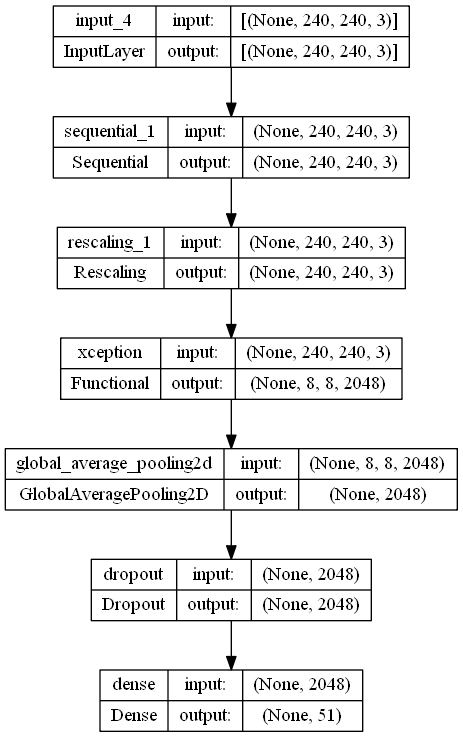

In [13]:
tf.keras.utils.plot_model(model, "modelo_tfg.png", show_shapes=True)

Functions that converts numpys to TFRecords

In [9]:

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def save_numpy_to_tfrecords(data, label, destination_path, name, fragmentSize,
                            current_batch_number, total_batch_number,
                            color_depth):
  """Converts an entire dataset into x tfrecords where x=videos/fragmentSize.

  Args:
    data: ndarray(uint32) of shape (v,i,h,w,c) with v=number of videos,
    i=number of images, c=number of image channels, h=image height, w=image
    width
    name: filename; data samples type (train|valid|test)
    fragmentSize: specifies how many videos are stored in one tfrecords file
    current_batch_number: indicates the current batch index (function call within loop)
    total_batch_number: indicates the total number of batches
  """

  num_videos = data.shape[0]
  num_images = data.shape[1]
  num_channels = data.shape[4]
  height = data.shape[2]
  width = data.shape[3]

  writer = None
  feature = {}

  for video_count in range((num_videos)):

    if video_count % fragmentSize == 0:
      if writer is not None:
        writer.close()
      filename = os.path.join(destination_path,
                              name + str(current_batch_number) + '_of_' + str(
                                total_batch_number) + '.tfrecords')
      print('Writing', filename)
      writer = tf.io.TFRecordWriter(filename)

    for image_count in range(num_images):
      path = 'blob' + '/' + str(image_count)
      image = data[video_count, image_count, :, :, :]
      image = image.astype(color_depth)
      image_raw = image.tobytes()

      feature[path] = _bytes_feature(image_raw)
      
    feature['label'] = _int64_feature(label)
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
  if writer is not None:
    writer.close()

Function that converts the videos from a split into TFRecords

In [ ]:

def split_to_tfrecords(split_data,split_number,split_type,n_videos_in_record):
    
    n_of_records=int(len(split_data)/n_videos_in_record)
    hmdb51_directory='../hmdb51_org/'

    i=0
    for batch in range(n_of_records):

        data=[]
        current_batch=split_data[i:i+n_videos_in_record]
        label_of_batch=current_batch[0][1]
    
        for name_and_label in current_batch:
            np_video=load_video(hmdb51_directory+name_and_label[1]+'/'+name_and_label[0],frames_per_video)
            data.append(np_video)
        
        path='../tfRecords/split'+str(split_number)+'/'+label_of_batch
        if not os.path.exists(path):
            os.makedirs(path)
        save_numpy_to_tfrecords(np.array(data), batch+1, path, split_type+'Batch_', n_videos_in_record,batch+1, total_batch_number=n_of_records, color_depth="uint8")
        i=i+n_videos_in_record

split_to_tfrecords(train_split1,1,'train',70)
split_to_tfrecords(test_split1,1,'test',30)


Function to load a video from a serialized example of a TFRecordDataset

In [ ]:

def load_video_from_tfrecord(serialized_example):
    
    video = []
    for image_count in range(frames_per_video):
        path = 'blob' + '/' + str(image_count)
        feature_dict = {
            path: tf.io.FixedLenFeature([], tf.string),
            'label':tf.io.FixedLenFeature([],tf.int64)
        }
        
        features = tf.io.parse_single_example(serialized_example,features=feature_dict)

        frame_raw = features[path]
        label=features['label']

        frame = tf.io.decode_raw(frame_raw,out_type=tf.uint8)
        frame = tf.reshape(frame, shape=[frame_size, frame_size, 3])

        video.append(frame)
    return (video,label)
'''
filename=['../tfRecords/split1/brush_hair/trainBatch_1_of_51.tfrecords']

raw_tfrecord=tf.data.TFRecordDataset(filename)

x=raw_tfrecord.take(1)
video=load_video_from_tfrecord(next(iter(x)))
to_gif(video[0])
'''

Function to load dataset

In [ ]:
def load_dataset(filenames, isLabeled=True):
    ignore_order = tf.data.Options()
    ignore_order.deterministic = False
    dataset=tf.data.TFRecordDataset(filenames)
    dataset=dataset.with_options(ignore_order)
    dataset=dataset.map(partial(load_video_from_tfrecord))


We start the training and testing of our first split.

In [ ]:
train_filenames=tf.io.gfile.glob('../tfRecords/split1/*/train*.tfrecords')
test_filenames=tf.io.gfile.glob('../tfRecords/split1/*/test*.tfrecords')
print(train_filenames)